In [1]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from math import exp

# PART 1

In [2]:
train_data=pd.read_csv("/Users/bhalli/Desktop/machine learning/assignment 4/PA4_dataset/train.csv")

In [3]:
test_data=pd.read_csv("/Users/bhalli/Desktop/machine learning/assignment 4/PA4_dataset/test.csv")

In [4]:
def remove_punctuation_marks(text):
    return re.sub(r"\W"," ",text)

In [5]:
def remove_hyperlink(text):
    return re.sub(r"https|http\S+"," ",text)

In [6]:
def remove_username(text):
    return re.sub(r"@\S+"," ",text)

In [7]:
def to_lower_case(text):
    return text.lower()

In [8]:
file = open("/Users/bhalli/Desktop/machine learning/assignment 4/PA4_dataset/stop_words.txt", "r")
stop_words= file.read().split()
file.close()

def remove_stop_words(text, stopwords_list):
    for word in stopwords_list:
        text=re.sub(f"\s{word} "," ",text)
        text=re.sub(f"^{word} ","",text)
        text=re.sub(f" {word}\.*$"," ",text)
    return text

In [9]:
train_data["Tweet"]=train_data["Tweet"].apply(remove_username)
train_data["Tweet"]=train_data["Tweet"].apply(remove_hyperlink)
train_data["Tweet"]=train_data["Tweet"].apply(remove_punctuation_marks)
train_data["Tweet"]=train_data["Tweet"].apply(to_lower_case)
train_data["Tweet"]=train_data["Tweet"].apply(remove_stop_words,args=(stop_words,))

In [10]:
test_data["Tweet"]=test_data["Tweet"].apply(remove_username)
test_data["Tweet"]=test_data["Tweet"].apply(remove_hyperlink)
test_data["Tweet"]=test_data["Tweet"].apply(remove_punctuation_marks)
test_data["Tweet"]=test_data["Tweet"].apply(to_lower_case)
test_data["Tweet"]=test_data["Tweet"].apply(remove_stop_words,args=(stop_words,))

# PART 2

In [11]:
def create_BOW_vocab(train):
    bow = set()
    for text in train:
        bow.update(text.split())
    return sorted(list(bow))

In [12]:
vocabulary_list=create_BOW_vocab(list(train_data["Tweet"]))

In [13]:
regex=re.compile("\d+")
vocabulary_list=[i for i in vocabulary_list if not regex.search(i)]

In [14]:
def BOW_feature_vectors(train, BOW):
    feature_vectors = list()
    for text in train:
        feature_every_text=[]
        for word in BOW:
            if word in text:
                feature_every_text.append(1)
            else:
                feature_every_text.append(0)
        feature_vectors.append(feature_every_text)
    return np.array(feature_vectors)

In [15]:
train_BOW=BOW_feature_vectors(train_data["Tweet"], vocabulary_list)

In [16]:
test_BOW=BOW_feature_vectors(test_data["Tweet"], vocabulary_list)

# PART 3

In [17]:
positive_sentiment=train_data["Sentiment"].replace({"positive":1,"negative":0,"neutral":0})
positive_sentiment_data=pd.DataFrame({"Sentiment":positive_sentiment,"Tweet":train_data["Tweet"]})
negative_sentiment=train_data["Sentiment"].replace({"positive":0,"negative":1,"neutral":0})
negative_sentiment_data=pd.DataFrame({"Sentiment":negative_sentiment,"Tweet":train_data["Tweet"]})
neutral_sentiment=train_data["Sentiment"].replace({"positive":0,"negative":0,"neutral":1})
neutral_sentiment_data=pd.DataFrame({"Sentiment":neutral_sentiment,"Tweet":train_data["Tweet"]})

In [18]:
def sigmoud(X,theta):
    h=np.matmul(X,theta)
    return 1/(1+np.exp(-1*h))

In [19]:
def predict(sigmoud_output_positive,sigmoud_output_negative,sigmoud_output_neutral):
        all_sigmouds=np.concatenate([sigmoud_output_positive,sigmoud_output_negative,sigmoud_output_neutral],axis=1)
        return np.argmax(all_sigmouds,axis=1)

In [20]:
def cross_entropy_loss(X,y,theta):
    m=X.shape[0]
    h=sigmoud(X,theta)
    df=pd.DataFrame({"h":h.flatten(),"y":y.flatten()})
    cost1=np.multiply(y,np.log10(h))
    cost2=np.multiply(1-y,np.log10(1-h))
    final_cost=-1*cost1.sum() -1*cost2.sum()
    return final_cost

In [21]:
def gradient_descent(X_training,X_validation, y_training,y_validation, theta, alpha,lmb,iter_num):
    all_training_loss=[]
    all_validation_loss=[]
    m=X_training.shape[0]
    for iteration in range(iter_num):
        all_training_loss.append(cross_entropy_loss(X_training,y_training,theta))
        all_validation_loss.append(cross_entropy_loss(X_validation, y_validation, theta))
        gradient = (np.matmul(X_training.T,sigmoud(X_training,theta)-y_training))+(2*lmb*theta)
        theta = theta-alpha*gradient
    return theta,all_training_loss,all_validation_loss

In [22]:
def training_and_vald_data(positive_sentiment_data):
    training_data_positive=positive_sentiment_data.sample(frac=0.8)
    validation_data_positive=positive_sentiment_data.drop(training_data_positive.index)
    X_training_positive=BOW_feature_vectors(training_data_positive["Tweet"],vocabulary_list)
    y_training_positive=np.array(training_data_positive[['Sentiment']])
    X_validation_positive=BOW_feature_vectors(validation_data_positive["Tweet"],vocabulary_list)
    y_validation_positive=np.array(validation_data_positive[['Sentiment']])
    bias_train=np.ones((tuple(X_training_positive.shape)[0],1))
    X_training_positive=np.append(bias_train,X_training_positive,axis=1)
    bias_validate=np.ones((tuple(X_validation_positive.shape)[0],1))
    X_validation_positive= np.append(bias_validate,X_validation_positive,axis=1)
    return X_training_positive,X_validation_positive,y_training_positive,y_validation_positive

In [23]:
def losses(tup,alpha):    
    all_training_loss_positive=[]
    all_validation_loss_positive=[]
    all_theta_positive=[]
    lmb=[1,5,10]
    tup=training_and_vald_data(positive_sentiment_data)
    for i in lmb:
        theta=np.zeros((len(vocabulary_list)+1,1))
        theta,training_loss,validation_loss=gradient_descent(tup[0],tup[1],tup[2],tup[3],theta,alpha,i,1000)
        all_training_loss_positive.append(training_loss)
        all_validation_loss_positive.append(validation_loss)
        all_theta_positive.append(theta)
    return all_training_loss_positive, all_validation_loss_positive,all_theta_positive

In [24]:
positive_sentiment_tup=training_and_vald_data(positive_sentiment_data)
negative_sentiment_tup=training_and_vald_data(negative_sentiment_data)
neutral_sentiment_tup=training_and_vald_data(neutral_sentiment_data)
lmb=[1,5,10]

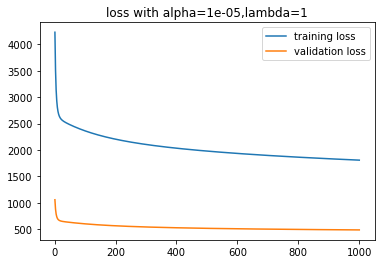

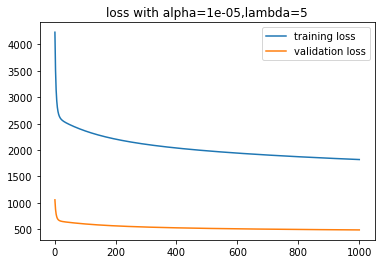

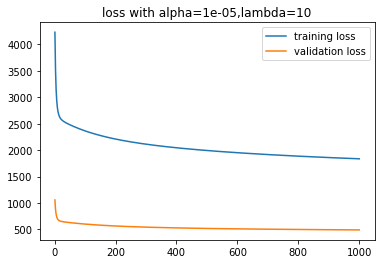

In [25]:
all_losses_theta_positive1=losses(positive_sentiment_tup,0.00001)
all_losses_theta_negative1=losses(negative_sentiment_tup,0.00001)
all_losses_theta_neutral1=losses(neutral_sentiment_tup,0.00001)
final_training_loss1=np.array(all_losses_theta_positive1[0]).T+np.array(all_losses_theta_negative1[0]).T+np.array(all_losses_theta_neutral1[0]).T
final_validation_loss1=np.array(all_losses_theta_positive1[1]).T+np.array(all_losses_theta_negative1[1]).T+np.array(all_losses_theta_neutral1[1]).T
for i in range(0,3):
    plt.figure()
    plt.plot(range(1,1001),final_training_loss1[:,i])
    plt.title(f'loss with alpha={0.00001},lambda={lmb[i]}')
    plt.plot(range(1,1001),final_validation_loss1[:,i])
    plt.title(f'loss with alpha={0.00001},lambda={lmb[i]}')
    plt.legend(["training loss","validation loss"])

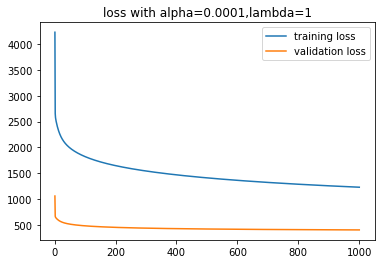

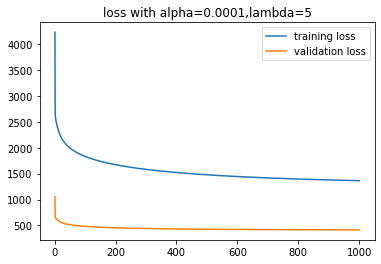

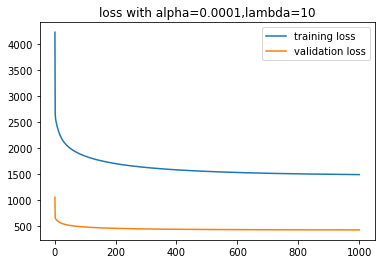

In [26]:
all_losses_theta_positive2=losses(positive_sentiment_tup,0.0001)
all_losses_theta_negative2=losses(negative_sentiment_tup,0.0001)
all_losses_theta_neutral2=losses(neutral_sentiment_tup,0.0001)
final_training_loss2=np.array(all_losses_theta_positive2[0]).T+np.array(all_losses_theta_negative2[0]).T+np.array(all_losses_theta_neutral2[0]).T
final_validation_loss2=np.array(all_losses_theta_positive2[1]).T+np.array(all_losses_theta_negative2[1]).T+np.array(all_losses_theta_neutral2[1]).T
for i in range(0,3):
    plt.figure()
    plt.plot(range(1,1001),final_training_loss2[:,i])
    plt.title(f'loss with alpha={0.0001},lambda={lmb[i]}')
    plt.plot(range(1,1001),final_validation_loss2[:,i])
    plt.title(f'loss with alpha={0.0001},lambda={lmb[i]}')
    plt.legend(["training loss","validation loss"])

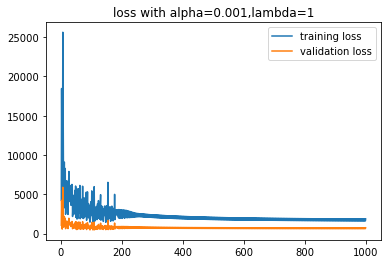

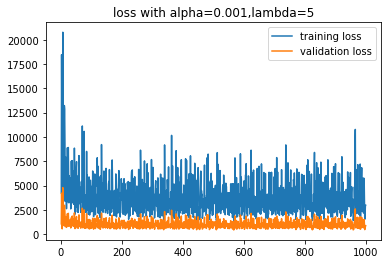

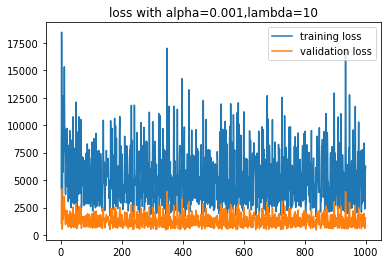

In [27]:
all_losses_theta_positive3=losses(positive_sentiment_tup,0.001)
all_losses_theta_negative3=losses(negative_sentiment_tup,0.001)
all_losses_theta_neutral3=losses(neutral_sentiment_tup,0.001)
final_training_loss3=np.array(all_losses_theta_positive3[0]).T+np.array(all_losses_theta_negative3[0]).T+np.array(all_losses_theta_neutral3[0]).T
final_validation_loss3=np.array(all_losses_theta_positive3[1]).T+np.array(all_losses_theta_negative3[1]).T+np.array(all_losses_theta_neutral3[1]).T
for i in range(0,3):
    plt.figure()
    plt.plot(range(1,1001),final_training_loss3[:,i])
    plt.title(f'loss with alpha={0.001},lambda={lmb[i]}')
    plt.plot(range(1,1001),final_validation_loss3[:,i])
    plt.title(f'loss with alpha={0.001},lambda={lmb[i]}')
    plt.legend(["training loss","validation loss"])

In [28]:
# using the graphs above, it can clearly be seen that the best values of are alpha=0.0001,lambda=5,epoch=600 
# since it converges cquicker and gives the lowest training and validation loss

In [129]:
final_positive_theta=all_losses_theta_positive2[2][1]
final_negative_theta=all_losses_theta_negative1[2][0]
final_neutral_theta=all_losses_theta_neutral3[2][2]

In [130]:
positive_sentiment_test=test_data

In [131]:
def test_data_final(positive_sentiment_data):
    training_data_positive=positive_sentiment_data
    X_training_positive=BOW_feature_vectors(training_data_positive["Tweet"],vocabulary_list)
    bias_train=np.ones((tuple(X_training_positive.shape)[0],1))
    X_training_positive=np.append(bias_train,X_training_positive,axis=1)
    return X_training_positive

In [132]:
X_positive_test=test_data_final(positive_sentiment_test)
X_negative_test=X_positive_test
X_neutral_test=X_positive_test

In [133]:
sigmoud_positive=sigmoud(X_positive_test,final_positive_theta)
sigmoud_negative=sigmoud(X_negative_test,final_negative_theta)
sigmoud_neutral=sigmoud(X_neutral_test,final_neutral_theta)

In [134]:
prediction_test=predict(sigmoud_positive,sigmoud_negative,sigmoud_neutral)

In [135]:
def evaluation_multi(true,predict,beta):
    true=true.replace({"positive":0,"negative":1,"neutral":2})
    unique_labels=np.unique(true)
    confusion_matrix=np.zeros((len(unique_labels),len(unique_labels)))
    for label in unique_labels:
        for i in range(true.shape[0]):
            if true[i]==predict[i] and predict[i]==label:
                confusion_matrix[int(label),int(label)]=confusion_matrix[int(label),int(label)]+1
            elif true[i]!=predict[i] and predict[i]==label:
                confusion_matrix[int(predict[i]),int(true[i])]=confusion_matrix[int(predict[i]),int(true[i])]+1
    correct_predicted=0
    sum_class_recall=0
    sum_class_precision=0
    for i in range(len(unique_labels)):
        correct_predicted=correct_predicted+float(confusion_matrix[i,i])
        sum_class_recall=sum_class_recall+(float(confusion_matrix[i,i]))/(confusion_matrix[:,i].sum())
        sum_class_precision=sum_class_precision+(float(confusion_matrix[i,i]))/(confusion_matrix[i,:].sum())
    accuracy=correct_predicted/(true.shape[0])
    recall=sum_class_recall/(len(unique_labels))
    precision=sum_class_precision/(len(unique_labels))
    f_score=((beta**2 +1)*precision*recall)/((beta**2)*precision + recall)
    return confusion_matrix,accuracy,f_score

In [136]:
tup_evaluation=evaluation_multi(test_data["Sentiment"],prediction_test,1)

In [137]:
print(f"accuracy:{tup_evaluation[1]}")
print(f"f1_score:{tup_evaluation[2]}")
print(f"confusion matrix:\n{tup_evaluation[0]}")

accuracy:0.6079234972677595
f1_score:0.43072255107062807
confusion matrix:
[[132. 174.  79.]
 [ 51. 750. 214.]
 [ 56.   0.   8.]]


# PART 4

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [66]:
X_train=BOW_feature_vectors(train_data["Tweet"],vocabulary_list)
y_train=train_data["Sentiment"].replace({"positive":0,"negative":1,"neutral":2})

In [67]:
clf=LogisticRegression(penalty='l2',multi_class='ovr',max_iter=1000)
clf.fit(X_train,y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [68]:
X_test=BOW_feature_vectors(test_data["Tweet"],vocabulary_list)
y_test=test_data["Sentiment"].replace({"positive":0,"negative":1,"neutral":2})

In [69]:
prediction=clf.predict(X_test)

In [70]:
accuracy=accuracy_score(y_test,prediction)
f1score=f1_score(y_test,prediction,average="macro")
cfm=confusion_matrix(y_test,prediction)

In [71]:
print(f"accuracy:{accuracy}")
print(f"f1_score:{f1score}")
print(f"confusion matrix:\n{cfm}")

accuracy:0.7452185792349727
f1_score:0.6654069414184286
confusion matrix:
[[140  52  47]
 [ 32 797  95]
 [ 28 119 154]]


# PART 5

In [72]:
def training_NB(X_training,y_training,vocabulary_list):
    unique_labels=np.unique(y_training)
    number_documnets=X_training.shape[0]
    prior_prob=np.zeros(np.unique(y_training).shape[0])
    likelihood=np.zeros((len(vocabulary_list),np.unique(y_training).shape[0]))
    i=0
    for c in unique_labels:
            number_documnets_with_c=np.sum(y_training==c)
            logprior_c=np.log10(number_documnets_with_c/number_documnets)
            prior_prob[i]=logprior_c
            training_set_combined=np.append(np.array(y_train).reshape(y_train.shape[0],1),train_BOW,axis=1)
            X_training_with_c=training_set_combined[training_set_combined[:,0]==c][:,1:]
            word_occurences_in_X_training_c=np.sum(X_training_with_c,axis=0)+1
            denominnator=np.sum(X_training_with_c) + len(vocabulary_list)
            likelihood_each_word=np.log10(word_occurences_in_X_training_c/denominnator)
            likelihood[:,i]=likelihood_each_word
            i=i+1
    return prior_prob,likelihood

In [73]:
train_porbabilities=training_NB(train_BOW,y_train,vocabulary_list)

In [74]:
def test_NB(X_test,prior_prob,likelihood):
    temp=np.matmul(X_test,likelihood)
    prob_each=temp+prior_prob
    return np.argmax(prob_each,axis=1)

In [75]:
prediction=test_NB(test_BOW,train_porbabilities[0],train_porbabilities[1])

In [76]:
evaluation_NB=evaluation_multi(test_data["Sentiment"],prediction,1)

In [77]:
print(f"accuracy:{evaluation_NB[1]}")
print(f"f1_score:{evaluation_NB[2]}")
print(f"confusion matrix:\n{evaluation_NB[0]}")

accuracy:0.7513661202185792
f1_score:0.660643582138617
confusion matrix:
[[134.  21.  33.]
 [ 63. 832. 134.]
 [ 42.  71. 134.]]


# PART 6

In [78]:
from sklearn.naive_bayes import MultinomialNB

In [79]:
clf_NB= MultinomialNB()

In [80]:
clf_NB.fit(train_BOW,y_train)

MultinomialNB()

In [81]:
prediction_NB_sklearn=clf_NB.predict(test_BOW)

In [82]:
accuracy_NB=accuracy_score(y_test,prediction_NB_sklearn)
f1score_NB=f1_score(y_test,prediction_NB_sklearn,average="macro")
cfm_NB=confusion_matrix(y_test,prediction_NB_sklearn)

In [83]:
print(f"accuracy:{accuracy_NB}")
print(f"f1_score:{f1score_NB}")
print(f"confusion matrix:\n{cfm_NB}")

accuracy:0.7513661202185792
f1_score:0.6562360949179803
confusion matrix:
[[134  63  42]
 [ 21 832  71]
 [ 33 134 134]]


Both part 4 and 6 have similar results. This is beacause under the right conditions, the Naive bayes is as good as
the logistic regression model,the condition being conditional independence of words given the class. In, other words,the assumption that a word is independent given the class is being validated.